# Intraday Momentum Breakout Strategy: End-to-End Backtest

**ES & NQ E-mini Futures Momentum Trading System**

This notebook demonstrates the complete workflow for the Intraday Momentum Breakout Strategy:
1. Data Acquisition (ES & NQ Futures)
2. Noise Area Calculation (90-day volatility boundaries)
3. Signal Generation (Breakout detection)
4. Position Sizing (Volatility targeting: 3% daily)
5. Backtesting (With realistic transaction costs)
6. Performance Evaluation

---

## Key Strategy Parameters

- **Noise Area Lookback**: 90 days (optimized from research)
- **Target Volatility**: 3% daily portfolio volatility
- **Max Leverage**: 8x
- **Portfolio Allocation**: 50% NQ momentum, 25% ES momentum, 25% NQ long-only
- **Transaction Costs**: 1 tick slippage per side + $4.20 commission
- **Trading Hours**: 9:30 AM - 4:00 PM ET (intraday only)

---

## 1. Setup & Imports

Import all required modules and configure settings.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from noise_area import NoiseAreaCalculator, visualize_noise_area
from signal_generator import SignalGenerator
from position_sizer import PositionSizer
from backtester import Backtester
from performance_evaluator import PerformanceEvaluator, visualize_performance
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All modules imported successfully")
print(f"Current directory: {os.getcwd()}")

✓ All modules imported successfully
Current directory: /home/misango/codechest/Algorithmic_Trading_and_HFT_Research/Algorithmic_Strategies/Intraday_Momentum_Breakout


## 2. Load Configuration

Load strategy parameters from config file.

In [2]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Display key parameters
print("="*60)
print("STRATEGY CONFIGURATION")
print("="*60)
print(f"\nNoise Area:")
print(f"  Lookback: {config['strategy']['noise_area']['lookback_days']} days")
print(f"  Method: {config['strategy']['noise_area']['method']}")
print(f"  Upper percentile: {config['strategy']['noise_area']['upper_percentile']}%")
print(f"  Lower percentile: {config['strategy']['noise_area']['lower_percentile']}%")

print(f"\nPosition Sizing:")
print(f"  Target volatility: {config['strategy']['position_sizing']['target_daily_volatility']}%")
print(f"  Max leverage: {config['strategy']['position_sizing']['max_leverage']}x")
print(f"  Volatility estimation: {config['strategy']['position_sizing']['volatility_estimation']}")

print(f"\nPortfolio Allocation:")
for strategy, allocation in config['strategy']['portfolio']['allocation'].items():
    print(f"  {strategy}: {allocation}%")

print(f"\nTransaction Costs:")
print(f"  Commission: ${config['strategy']['transaction_costs']['commission_per_contract']:.2f} per contract")
print(f"  Slippage: {config['strategy']['transaction_costs']['slippage_ticks']} ticks per side")
print(f"  ES tick value: ${config['strategy']['transaction_costs']['ES']['tick_value']:.2f}")
print(f"  NQ tick value: ${config['strategy']['transaction_costs']['NQ']['tick_value']:.2f}")

print(f"\nBacktest Period:")
print(f"  Start: {config['data']['start_date']}")
print(f"  End: {config['data']['end_date']}")
print(f"  Initial Capital: ${config['strategy']['portfolio']['initial_capital']:,}")
print("="*60)

STRATEGY CONFIGURATION

Noise Area:
  Lookback: 30 days
  Method: percentile
  Upper percentile: 75%
  Lower percentile: 25%

Position Sizing:
  Target volatility: 3.0%
  Max leverage: 8.0x
  Volatility estimation: ewma

Portfolio Allocation:
  NQ_momentum: 0.5%
  ES_momentum: 0.25%
  NQ_long_only: 0.25%

Transaction Costs:
  Commission: $4.20 per contract
  Slippage: 1.0 ticks per side
  ES tick value: $12.50
  NQ tick value: $5.00

Backtest Period:
  Start: 2018-01-01
  End: None
  Initial Capital: $100,000


## 3. Data Acquisition

Load ES & NQ futures data from real Databento CSV files (RTH, 5-minute bars).

In [3]:
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)
with open('config.yaml', 'r') as f:
    base_config = yaml.safe_load(f)
es_data = pd.read_csv(
    "/home/misango/codechest/Algorithmic_Trading_and_HFT_Research/Algorithmic_Strategies/Intraday_Momentum_Breakout/Data/ES_5min_RTH.csv"
)
es_data['ts_event'] = pd.to_datetime(es_data['ts_event'], utc=True)
es_data = es_data.set_index('ts_event')
nq_data = pd.read_csv(
    "/home/misango/codechest/Algorithmic_Trading_and_HFT_Research/Algorithmic_Strategies/Intraday_Momentum_Breakout/Data/NQ_5min_RTH.csv"
)
nq_data['ts_event'] = pd.to_datetime(nq_data['ts_event'], utc=True)
nq_data = nq_data.set_index('ts_event')
print(f"✓ Data loaded: {len(es_data)} ES bars, {len(nq_data)} NQ bars")
print(f"✓ Date range: {es_data.index.min()} to {es_data.index.max()}")
print(f"✓ Index type: {type(es_data.index).__name__}")

✓ Data loaded: 297665 ES bars, 297665 NQ bars
✓ Date range: 2011-01-03 14:30:00+00:00 to 2026-02-25 21:00:00+00:00
✓ Index type: DatetimeIndex


### Visualize Raw Data

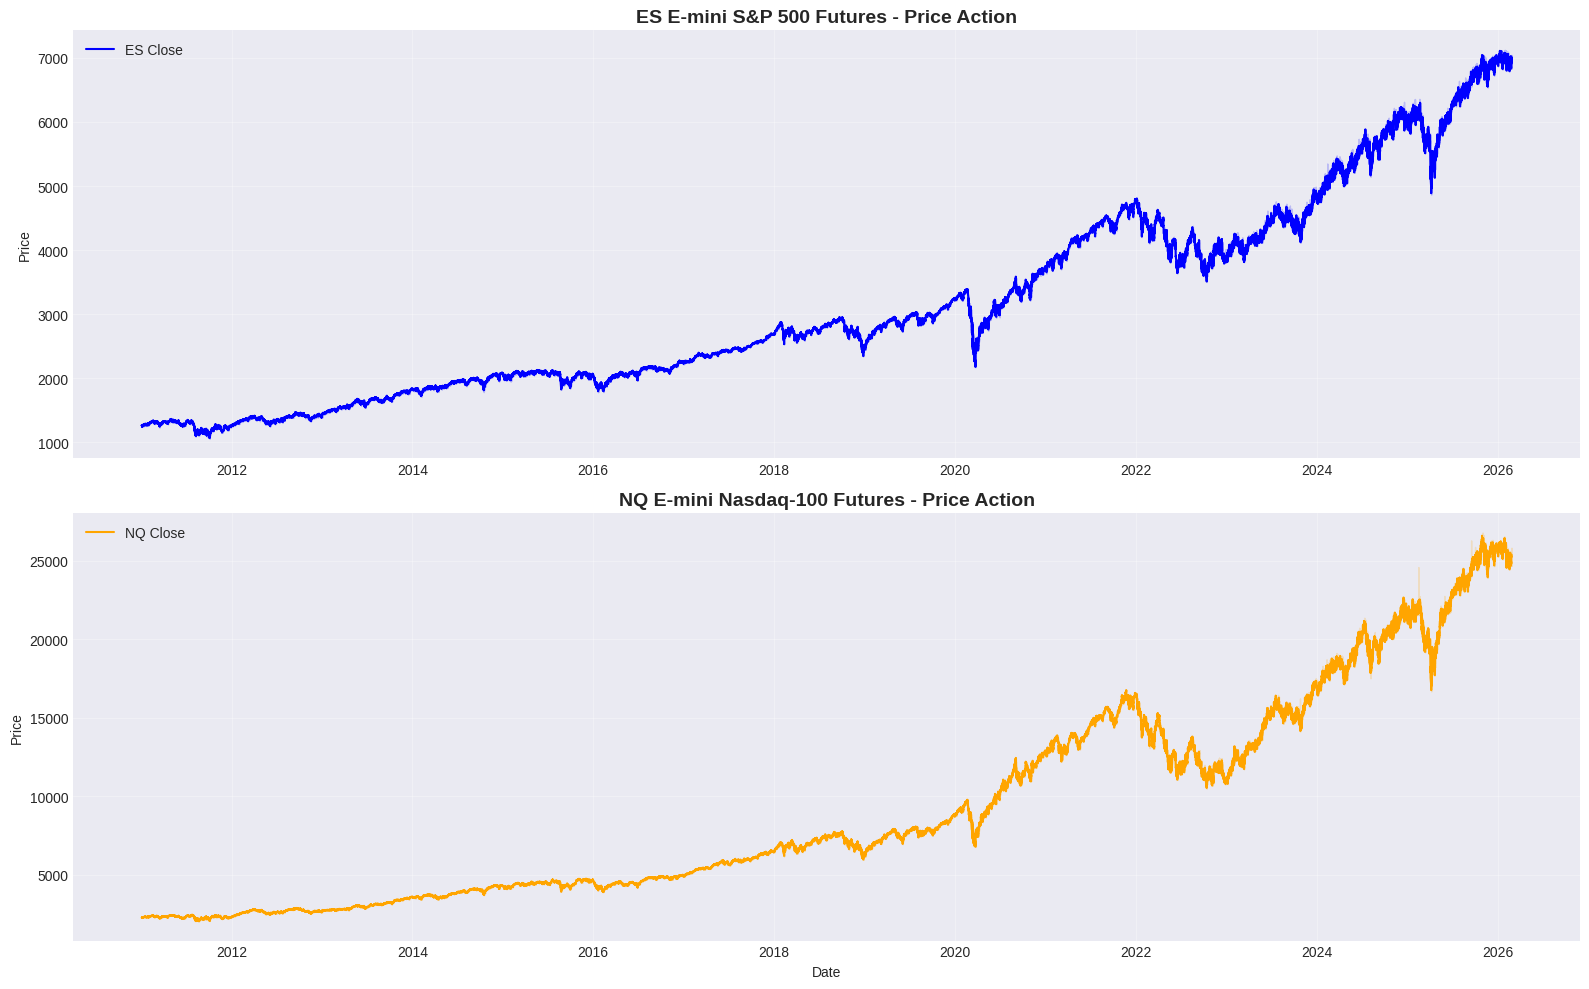

✓ Raw data visualization saved


In [4]:
# Plot raw price data
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ES
ax = axes[0]
ax.plot(es_data.index, es_data['Close'], linewidth=1.5, label='ES Close', color='blue')
ax.fill_between(es_data.index, es_data['Low'], es_data['High'], alpha=0.2, color='blue')
ax.set_title('ES E-mini S&P 500 Futures - Price Action', fontsize=14, fontweight='bold')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)

# NQ
ax = axes[1]
ax.plot(nq_data.index, nq_data['Close'], linewidth=1.5, label='NQ Close', color='orange')
ax.fill_between(nq_data.index, nq_data['Low'], nq_data['High'], alpha=0.2, color='orange')
ax.set_title('NQ E-mini Nasdaq-100 Futures - Price Action', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/01_raw_price_data.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Raw data visualization saved")

## 4. Noise Area Calculation

Calculate volatility-based boundaries that define "normal" price fluctuation.

In [5]:
import importlib, noise_area as _na_mod
importlib.reload(_na_mod)
from noise_area import NoiseAreaCalculator

# Reload data to get a clean frame before adding noise_area columns
es_data_raw = pd.read_csv(
    "/home/misango/codechest/Algorithmic_Trading_and_HFT_Research/Algorithmic_Strategies/Intraday_Momentum_Breakout/Data/ES_5min_RTH.csv"
)
es_data_raw['ts_event'] = pd.to_datetime(es_data_raw['ts_event'], utc=True)
es_data_raw = es_data_raw.set_index('ts_event')

nq_data_raw = pd.read_csv(
    "/home/misango/codechest/Algorithmic_Trading_and_HFT_Research/Algorithmic_Strategies/Intraday_Momentum_Breakout/Data/NQ_5min_RTH.csv"
)
nq_data_raw['ts_event'] = pd.to_datetime(nq_data_raw['ts_event'], utc=True)
nq_data_raw = nq_data_raw.set_index('ts_event')

# Initialize calculator with updated module
calculator = NoiseAreaCalculator(config)

# Calculate noise area for ES
print("\nCalculating noise area for ES...")
es_data = calculator.calculate_noise_area(es_data_raw.copy())
es_data = calculator.identify_breakouts(es_data)

# Calculate noise area for NQ
print("\nCalculating noise area for NQ...")
nq_data = calculator.calculate_noise_area(nq_data_raw.copy())
nq_data = calculator.identify_breakouts(nq_data)

print(f"\n✓ Noise area calculation complete")
print(f"  ES NaN boundaries: {es_data['upper_boundary'].isna().sum()}")
print(f"  NQ NaN boundaries: {nq_data['upper_boundary'].isna().sum()}")


Calculating noise area for ES...
NOISE AREA CALCULATION
Calculating noise area using percentile method (30 days)...
  Filtered 5.9% outlier days (range > 135.75)
  Calculated noise area for 297665 bars
  Avg upper range: 46.30
  Avg lower range: 37.02

Validation:
  Valid boundaries: 100.0%
  Avg boundary width: 83.32

Calculating noise area for NQ...
NOISE AREA CALCULATION
Calculating noise area using percentile method (30 days)...
  Filtered 2.3% outlier days (range > 543.75)
  Calculated noise area for 297665 bars
  Avg upper range: 137.19
  Avg lower range: 105.57

Validation:
  Valid boundaries: 100.0%
  Avg boundary width: 242.77

✓ Noise area calculation complete
  ES NaN boundaries: 0
  NQ NaN boundaries: 0


### Visualize Noise Area & Breakouts

  [ES] Resampled to 3,768 daily bars for overview chart

Noise area visualization saved to results/ES_noise_area.png


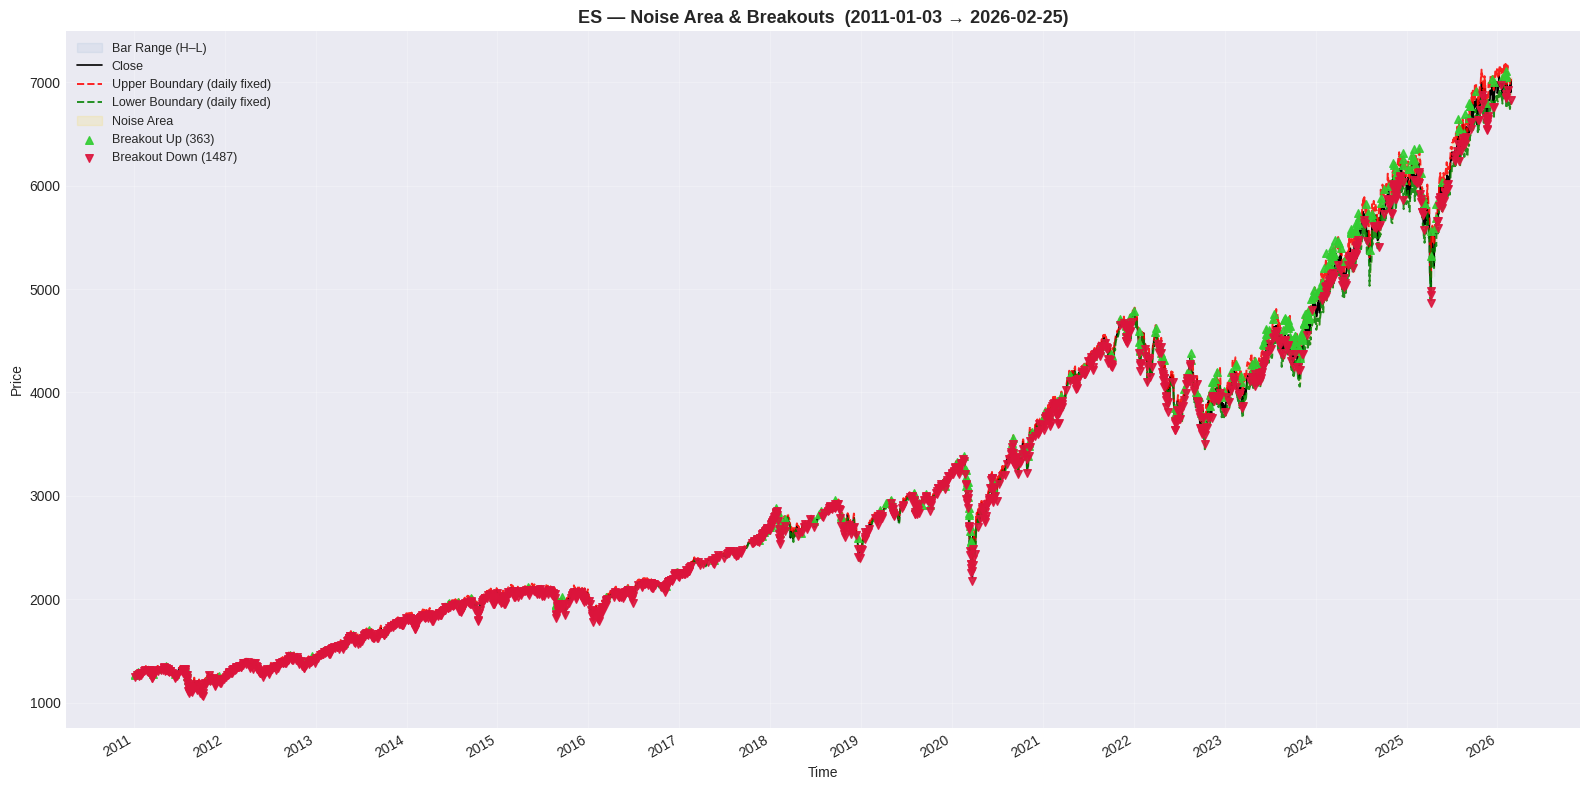

  [NQ] Resampled to 3,768 daily bars for overview chart

Noise area visualization saved to results/NQ_noise_area.png


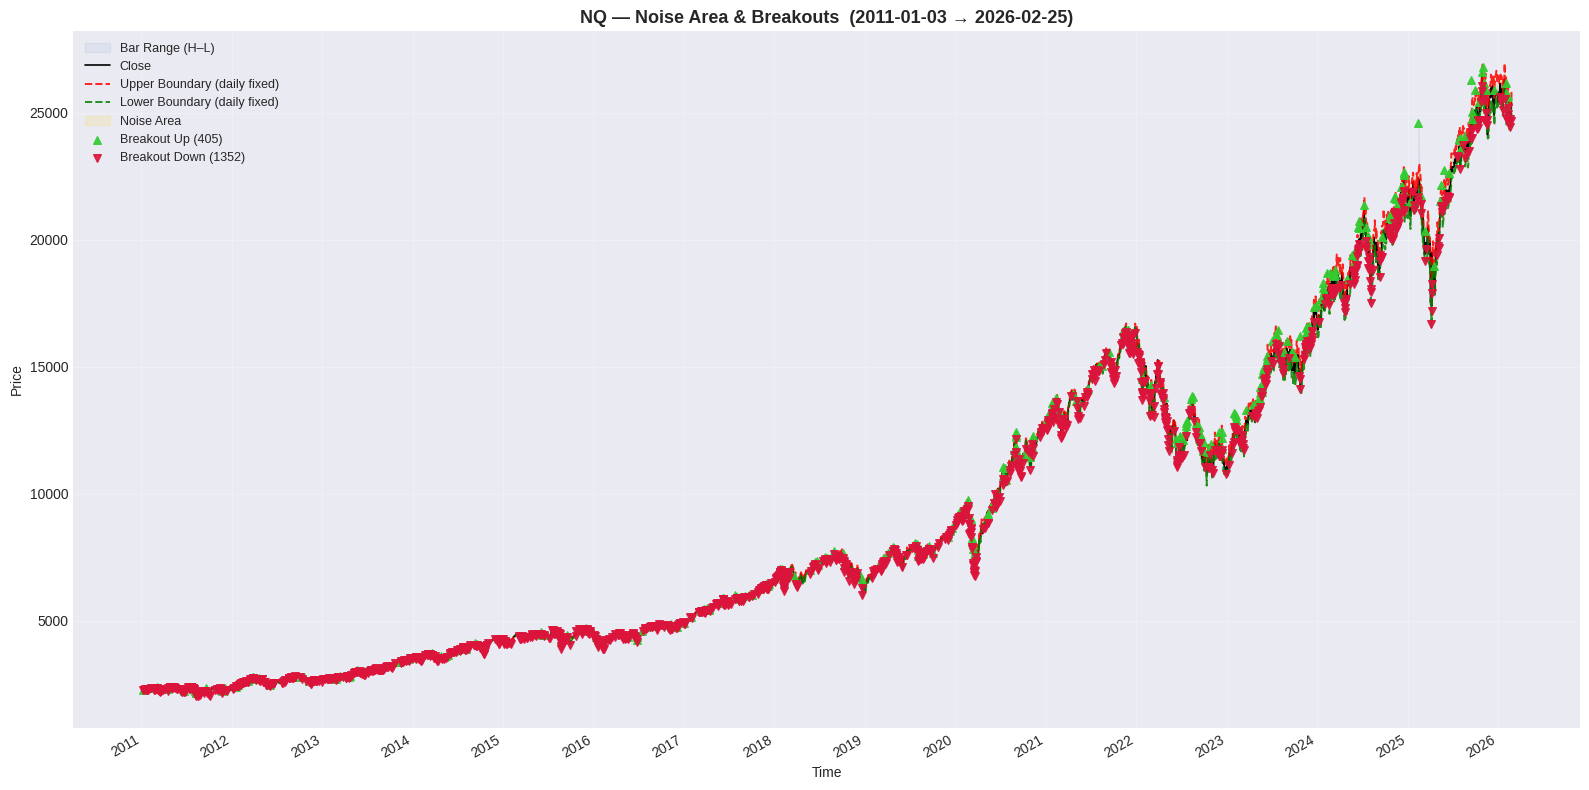

✓ Noise area visualizations created


In [6]:
import importlib
import noise_area as _na_mod
importlib.reload(_na_mod)
from noise_area import visualize_noise_area
# Show full 15+ year history — auto-resampled to daily bars for readability
visualize_noise_area(es_data, 'ES', start_idx=0, end_idx=len(es_data), config=config)
visualize_noise_area(nq_data, 'NQ', start_idx=0, end_idx=len(nq_data))
print("✓ Noise area visualizations created")


### Breakout Statistics

In [7]:
# ES breakout stats
print("="*60)
print("ES BREAKOUT STATISTICS")
print("="*60)
print(f"Total bars: {len(es_data)}")
print(f"Break above: {es_data['break_above'].sum()} bars ({es_data['break_above'].mean()*100:.2f}%)")
print(f"Break below: {es_data['break_below'].sum()} bars ({es_data['break_below'].mean()*100:.2f}%)")
print(f"Inside noise: {es_data['inside_noise'].sum()} bars ({es_data['inside_noise'].mean()*100:.2f}%)")
print(f"Momentum failures: {es_data['momentum_failure'].sum()}")

print("\n" + "="*60)
print("NQ BREAKOUT STATISTICS")
print("="*60)
print(f"Total bars: {len(nq_data)}")
print(f"Break above: {nq_data['break_above'].sum()} bars ({nq_data['break_above'].mean()*100:.2f}%)")
print(f"Break below: {nq_data['break_below'].sum()} bars ({nq_data['break_below'].mean()*100:.2f}%)")
print(f"Inside noise: {nq_data['inside_noise'].sum()} bars ({nq_data['inside_noise'].mean()*100:.2f}%)")
print(f"Momentum failures: {nq_data['momentum_failure'].sum()}")

ES BREAKOUT STATISTICS
Total bars: 297665
Break above: 705 bars (0.24%)
Break below: 4237 bars (1.42%)
Inside noise: 292776 bars (98.36%)
Momentum failures: 3665

NQ BREAKOUT STATISTICS
Total bars: 297665
Break above: 712 bars (0.24%)
Break below: 3088 bars (1.04%)
Inside noise: 293873 bars (98.73%)
Momentum failures: 3319


## 5. Signal Generation

Generate trading signals based on breakout detection with confirmation and volume filters.

In [8]:
import importlib, signal_generator as _sg_mod
importlib.reload(_sg_mod)
from signal_generator import SignalGenerator

# Re-initialize with reloaded module (UTC-aware session timing fix)
signal_gen = SignalGenerator(config)

# Generate signals for ES
print("\nGenerating signals for ES...")
es_data = signal_gen.generate_signals(es_data)

# Generate signals for NQ
print("\nGenerating signals for NQ...")
nq_data = signal_gen.generate_signals(nq_data)

print("\n✓ Signal generation complete")



Generating signals for ES...
SIGNAL GENERATION
Processing 297665 bars...

Signal Statistics:
  Entry signals: 2039
    Long: 281
    Short: 1758
  Exit signals: 2039
  Exit reasons:
    momentum_failure: 2039
  Avg signal strength: 27.7

Generating signals for NQ...
SIGNAL GENERATION
Processing 297665 bars...

Signal Statistics:
  Entry signals: 2141
    Long: 394
    Short: 1747
  Exit signals: 2141
  Exit reasons:
    momentum_failure: 2141
  Avg signal strength: 29.3

✓ Signal generation complete


### Signal Analysis

In [9]:
# ES signal stats
es_entries = es_data[es_data['entry_signal']]
es_exits = es_data[es_data['exit_signal']]

print("="*60)
print("ES SIGNAL STATISTICS")
print("="*60)
print(f"Entry signals: {len(es_entries)}")
print(f"  Long: {(es_entries['signal'] == 1).sum()}")
print(f"  Short: {(es_entries['signal'] == -1).sum()}")
print(f"Exit signals: {len(es_exits)}")
if len(es_exits) > 0:
    print(f"  Exit reasons:")
    for reason, count in es_exits['exit_reason'].value_counts().items():
        print(f"    {reason}: {count}")
print(f"Avg signal strength: {es_entries['signal_strength'].mean():.1f}")

# NQ signal stats
nq_entries = nq_data[nq_data['entry_signal']]
nq_exits = nq_data[nq_data['exit_signal']]

print("\n" + "="*60)
print("NQ SIGNAL STATISTICS")
print("="*60)
print(f"Entry signals: {len(nq_entries)}")
print(f"  Long: {(nq_entries['signal'] == 1).sum()}")
print(f"  Short: {(nq_entries['signal'] == -1).sum()}")
print(f"Exit signals: {len(nq_exits)}")
if len(nq_exits) > 0:
    print(f"  Exit reasons:")
    for reason, count in nq_exits['exit_reason'].value_counts().items():
        print(f"    {reason}: {count}")
print(f"Avg signal strength: {nq_entries['signal_strength'].mean():.1f}")

ES SIGNAL STATISTICS
Entry signals: 2039
  Long: 281
  Short: 1758
Exit signals: 2039
  Exit reasons:
    momentum_failure: 2039
Avg signal strength: 27.7

NQ SIGNAL STATISTICS
Entry signals: 2141
  Long: 394
  Short: 1747
Exit signals: 2141
  Exit reasons:
    momentum_failure: 2141
Avg signal strength: 29.3


### Visualize Signals

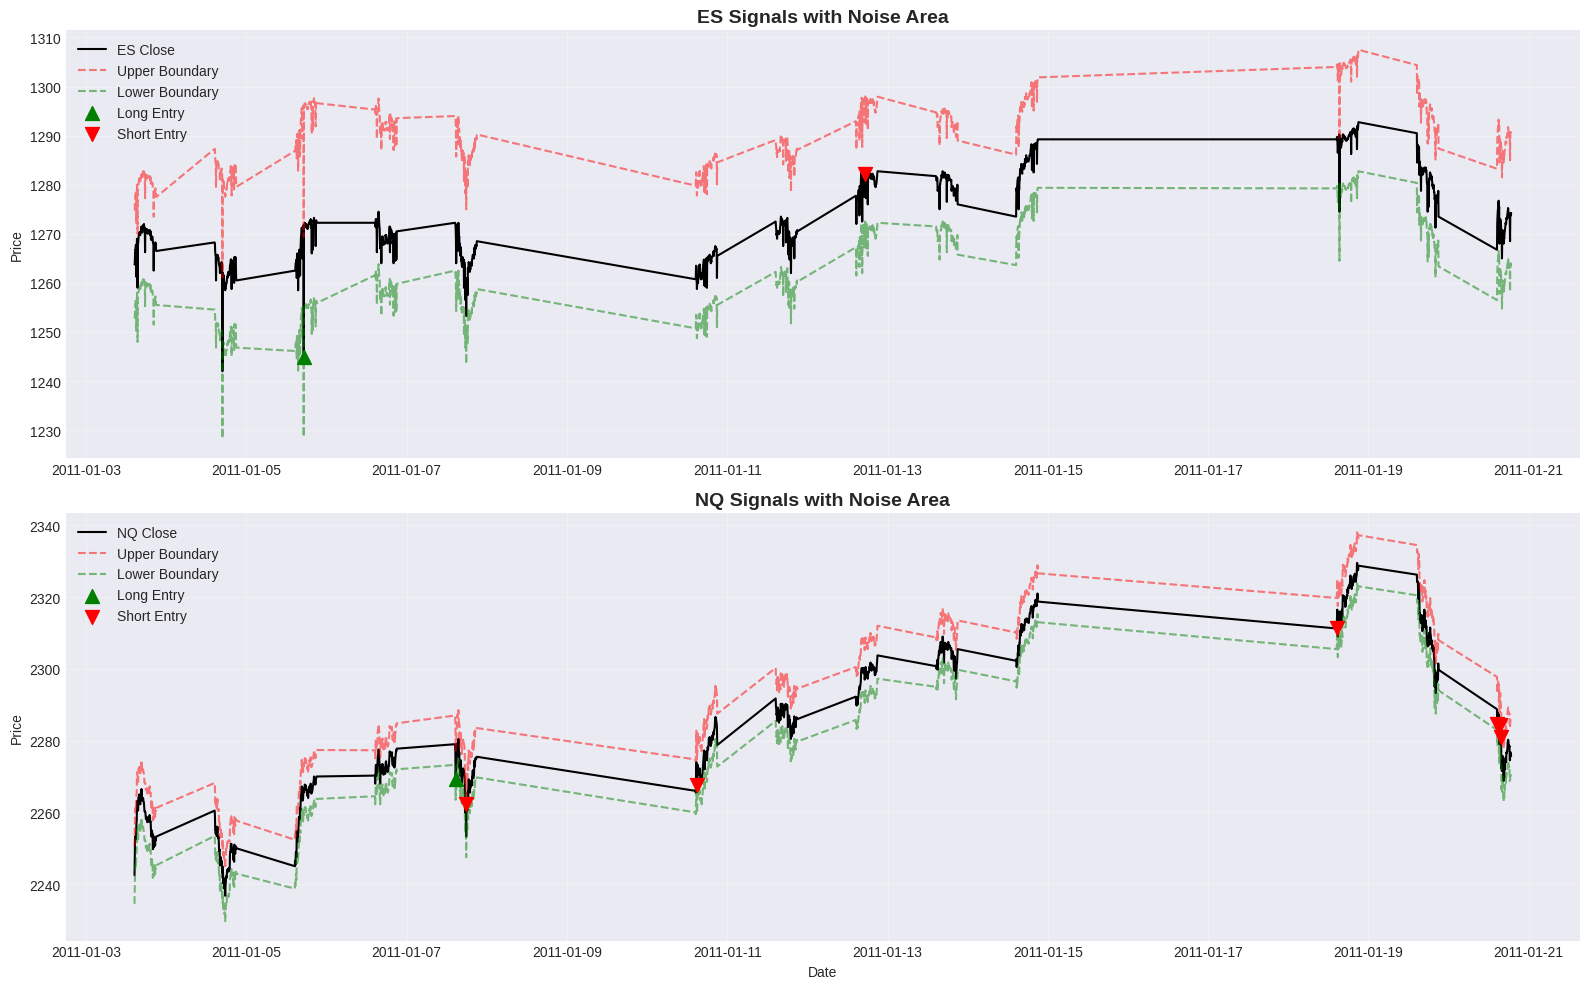

✓ Signal visualizations created


In [ ]:
import matplotlib.dates as mdates

def plot_signals_overview(data, symbol, color):
    """Plot full-history signals chart, resampled to daily if needed."""
    # Build daily-resampled view for overview
    agg = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
           'upper_boundary': 'mean', 'lower_boundary': 'mean',
           'entry_signal': 'any', 'exit_signal': 'any'}
    # carry signal direction for the day (last non-zero value)
    data['_sig_last'] = data['signal'].where(data['entry_signal'], other=pd.NA).ffill()
    agg['_sig_last'] = 'last'

    daily = data.resample('1B').agg(agg).dropna(subset=['Close'])
    daily['entry_signal'] = daily['entry_signal'].fillna(False)

    fig, ax = plt.subplots(figsize=(18, 7))

    # Price spine
    ax.plot(daily.index, daily['Close'], linewidth=1.2, color='black', label='Close', zorder=3)

    # Boundaries
    ax.plot(daily.index, daily['upper_boundary'], linestyle='--', color='red',
            alpha=0.6, linewidth=1.2, label='Upper Boundary')
    ax.plot(daily.index, daily['lower_boundary'], linestyle='--', color='green',
            alpha=0.6, linewidth=1.2, label='Lower Boundary')
    ax.fill_between(daily.index, daily['lower_boundary'], daily['upper_boundary'],
                    alpha=0.08, color='gold', label='Noise Area')

    # Entry markers (daily granularity for legibility)
    long_days  = daily[daily['entry_signal'] & (daily['_sig_last'] == 1)]
    short_days = daily[daily['entry_signal'] & (daily['_sig_last'] == -1)]
    ax.scatter(long_days.index,  long_days['High']  * 1.001, marker='^', s=60,
               color='limegreen', label=f'Long Entry ({len(long_days)})', zorder=5, alpha=0.9)
    ax.scatter(short_days.index, short_days['Low'] * 0.999, marker='v', s=60,
               color='crimson',   label=f'Short Entry ({len(short_days)})', zorder=5, alpha=0.9)

    span_days = (daily.index[-1] - daily.index[0]).days
    if span_days > 365 * 2:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
    elif span_days > 180:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
    else:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    ax.set_title(f'{symbol} — Signals with Noise Area  '
                 f'({daily.index[0].strftime("%Y-%m-%d")} → {daily.index[-1].strftime("%Y-%m-%d")})',
                 fontsize=13, fontweight='bold')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.25)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(f'results/02_{symbol}_signals.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  [{symbol}] {len(long_days)} long days, {len(short_days)} short days plotted")

plot_signals_overview(es_data.copy(), 'ES', 'blue')
plot_signals_overview(nq_data.copy(), 'NQ', 'orange')
print("✓ Signal visualizations created")


## 6. Position Sizing

Calculate position sizes using volatility targeting to maintain 3% daily portfolio volatility.

In [11]:
# Initialize position sizer
sizer = PositionSizer(config)

# Calculate positions for portfolio
portfolio = sizer.calculate_portfolio_positions(es_data, nq_data)

print("\n✓ Position sizing complete")

POSITION SIZING
Portfolio value: $100,000
Target volatility: 3.0%
Leverage bounds: 1.0x - 8.0x

Calculating volatility...
  ES avg vol: 44.5%
  NQ avg vol: 38.0%

Calculating position sizes...

Position Statistics:
  ES momentum:
    Avg position: 0.0 contracts
    Max position: 0 contracts
    Avg leverage: 0.00x
  NQ momentum:
    Avg position: 0.0 contracts
    Max position: 0 contracts
    Avg leverage: 0.00x
  NQ long-only:
    Avg position: 0.0 contracts
    Max position: 0 contracts
    Avg leverage: 0.00x

✓ Position sizing complete


### Position Size Analysis

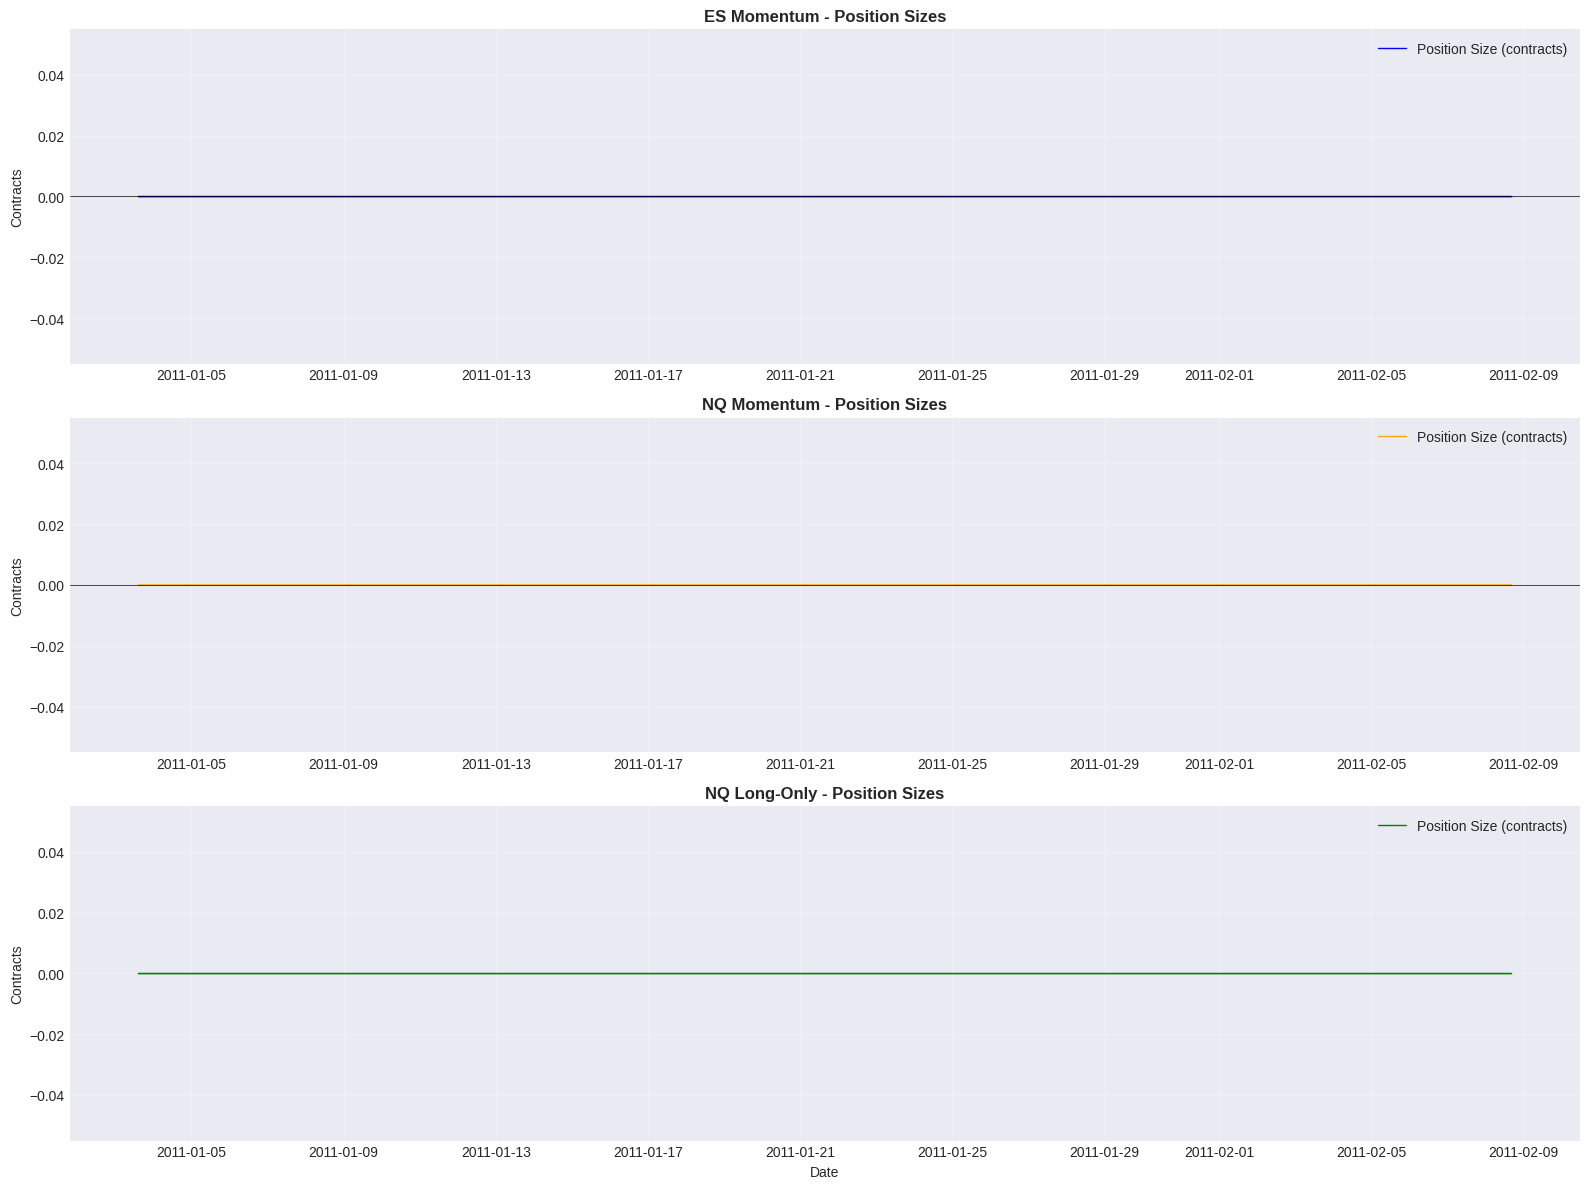

✓ Position size visualization created


In [12]:
# Analyze position sizes
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# ES momentum
ax = axes[0]
plot_data = portfolio['ES_momentum'].iloc[:min(2000, len(portfolio['ES_momentum']))]
ax.plot(plot_data.index, plot_data['position_size'], linewidth=1, label='Position Size (contracts)', color='blue')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.fill_between(plot_data.index, 0, plot_data['position_size'], alpha=0.3, color='blue')
ax.set_title('ES Momentum - Position Sizes', fontsize=12, fontweight='bold')
ax.set_ylabel('Contracts')
ax.legend()
ax.grid(True, alpha=0.3)

# NQ momentum
ax = axes[1]
plot_data = portfolio['NQ_momentum'].iloc[:min(2000, len(portfolio['NQ_momentum']))]
ax.plot(plot_data.index, plot_data['position_size'], linewidth=1, label='Position Size (contracts)', color='orange')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.fill_between(plot_data.index, 0, plot_data['position_size'], alpha=0.3, color='orange')
ax.set_title('NQ Momentum - Position Sizes', fontsize=12, fontweight='bold')
ax.set_ylabel('Contracts')
ax.legend()
ax.grid(True, alpha=0.3)

# NQ long-only
ax = axes[2]
plot_data = portfolio['NQ_long_only'].iloc[:min(2000, len(portfolio['NQ_long_only']))]
ax.plot(plot_data.index, plot_data['position_size'], linewidth=1, label='Position Size (contracts)', color='green')
ax.fill_between(plot_data.index, 0, plot_data['position_size'], alpha=0.3, color='green')
ax.set_title('NQ Long-Only - Position Sizes', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Contracts')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/03_position_sizes.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Position size visualization created")

## 7. Backtesting

Run event-driven backtest with realistic transaction costs (1 tick slippage + commission).

In [13]:
# Initialize backtester
backtester = Backtester(config)

# Run backtest
equity_curve = backtester.run_backtest(portfolio)
trades_df = backtester.get_trades_dataframe()

print("\n✓ Backtesting complete")

BACKTESTING
Initial capital: $100,000
Transaction costs:
  Slippage: 1.0 ticks per side
  Commission: $4.20 per contract

Backtesting 297665 bars...

Backtest Complete!
Total trades: 0
Final portfolio value: $100,000
Total return: 0.00%

✓ Backtesting complete


### Quick Equity Curve Preview

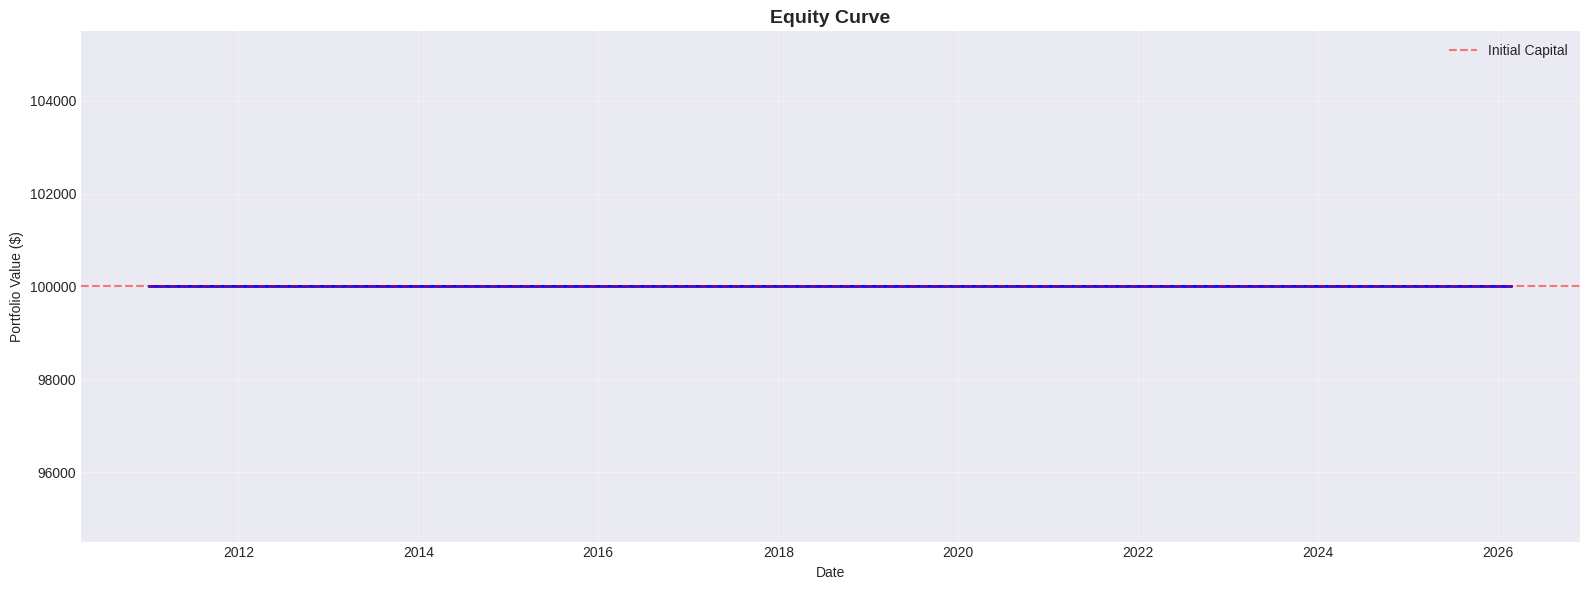


Total Return: 0.00%
Final Portfolio Value: $100,000
Total Trades: 0


In [14]:
# Plot equity curve
plt.figure(figsize=(16, 6))
plt.plot(equity_curve.index, equity_curve['portfolio_value'], linewidth=2, color='blue')
plt.axhline(y=config['strategy']['portfolio']['initial_capital'], color='red', 
            linestyle='--', alpha=0.5, label='Initial Capital')
plt.title('Equity Curve', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/04_equity_curve_preview.png', dpi=150, bbox_inches='tight')
plt.show()

# Quick stats
total_return = (equity_curve['portfolio_value'].iloc[-1] / equity_curve['portfolio_value'].iloc[0] - 1) * 100
print(f"\nTotal Return: {total_return:.2f}%")
print(f"Final Portfolio Value: ${equity_curve['portfolio_value'].iloc[-1]:,.0f}")
print(f"Total Trades: {len(trades_df)}")

## 8. Performance Evaluation

Calculate comprehensive performance metrics and generate visualizations.

In [15]:
# Initialize evaluator
evaluator = PerformanceEvaluator(config)

# Evaluate performance
metrics = evaluator.evaluate_strategy(equity_curve, trades_df)

print("\n✓ Performance evaluation complete")

PERFORMANCE EVALUATION

Returns:
  Total Return: 0.00%
  Annualized Return: 0.00%
  Annualized Volatility: 0.00%

Risk-Adjusted Metrics:
  Sharpe Ratio: 0.00
  Sortino Ratio: 0.00
  Calmar Ratio: 0.00

Drawdown:
  Max Drawdown: 0.00%
  Peak: 2011-01-03 14:30:00+00:00
  Trough: 2011-01-03 14:30:00+00:00

✓ Performance evaluation complete


### Comprehensive Visualizations


Performance visualization saved to results/performance_visualization.png


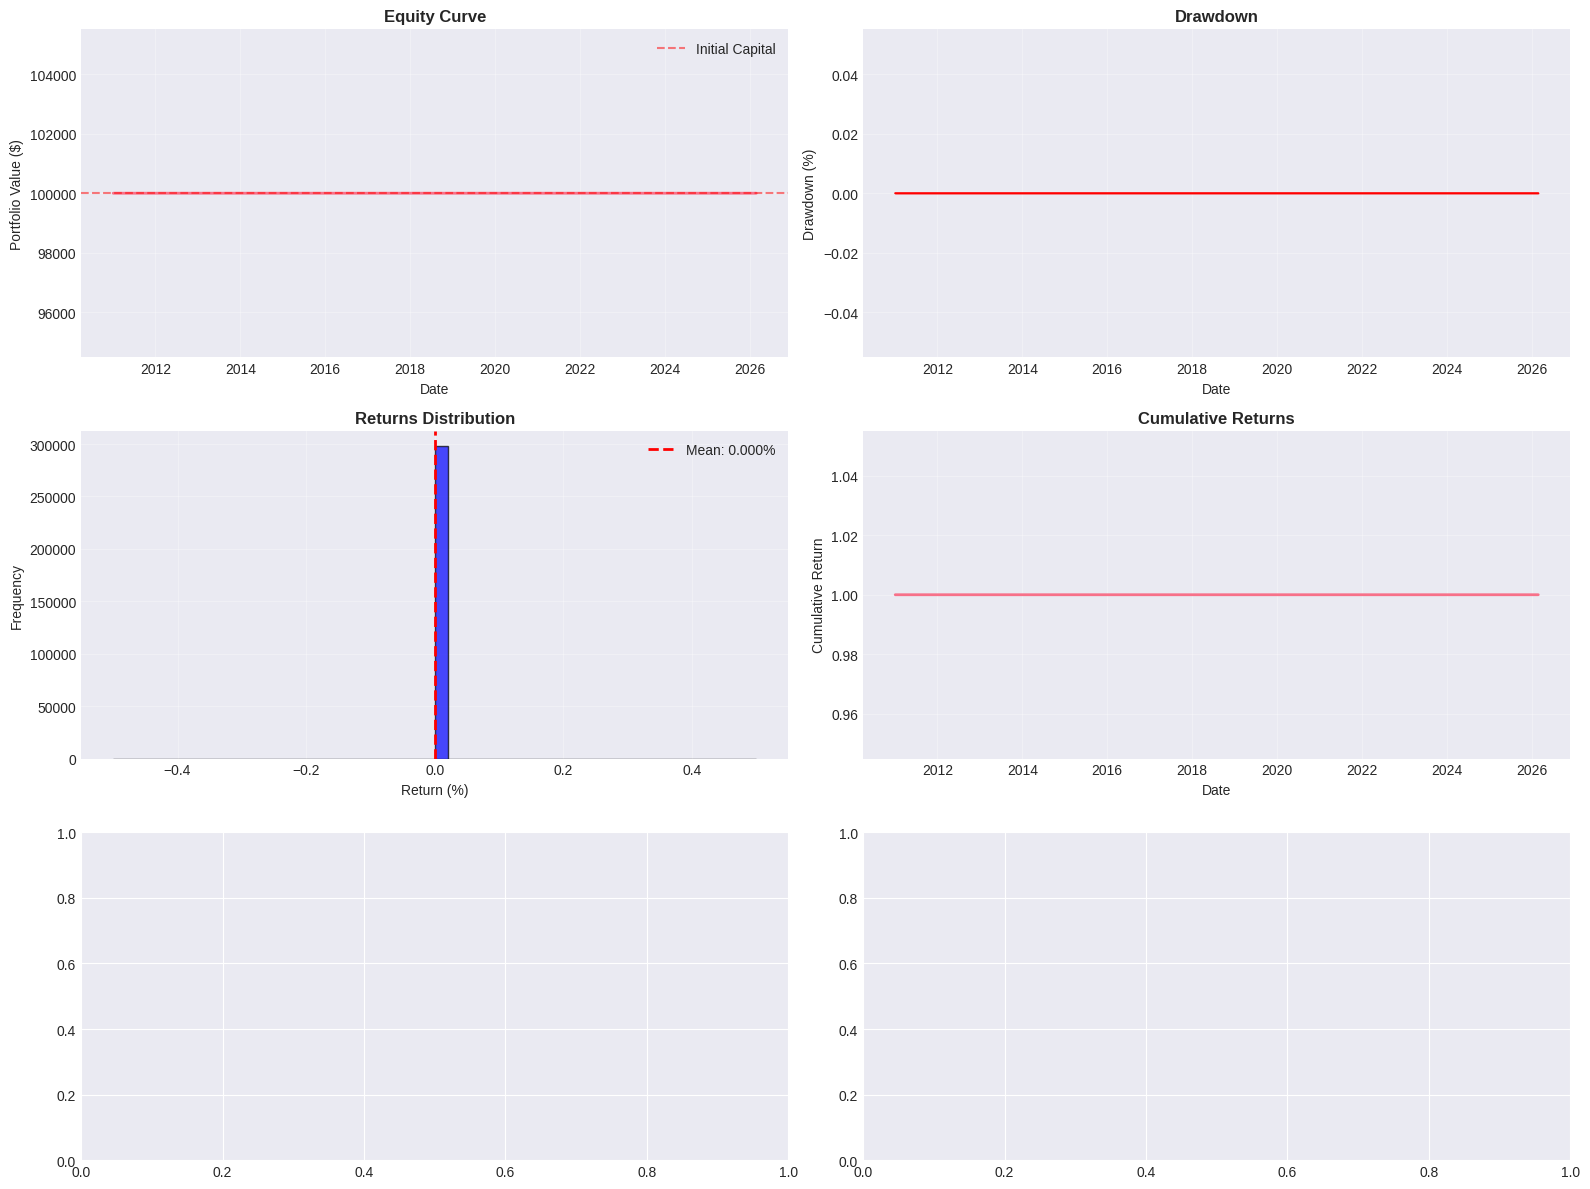

In [16]:
# Generate full performance visualization
visualize_performance(equity_curve, trades_df, metrics)

## 9. Detailed Trade Analysis

In [17]:
if len(trades_df) > 0:
    print("="*60)
    print("TRADE ANALYSIS")
    print("="*60)
    
    # By symbol
    print("\nTrades by Symbol:")
    print(trades_df['symbol'].value_counts())
    
    # By side
    print("\nTrades by Side:")
    print(trades_df['side'].value_counts())
    
    # By exit reason
    print("\nExit Reasons:")
    print(trades_df['exit_reason'].value_counts())
    
    # Top 10 winning trades
    print("\nTop 10 Winning Trades:")
    top_winners = trades_df.nlargest(10, 'pnl_net')[['timestamp', 'symbol', 'side', 'pnl_net', 'holding_bars']]
    print(top_winners.to_string(index=False))
    
    # Top 10 losing trades
    print("\nTop 10 Losing Trades:")
    top_losers = trades_df.nsmallest(10, 'pnl_net')[['timestamp', 'symbol', 'side', 'pnl_net', 'holding_bars']]
    print(top_losers.to_string(index=False))
    
    # Distribution of holding periods
    plt.figure(figsize=(12, 5))
    plt.hist(trades_df['holding_bars'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=trades_df['holding_bars'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {trades_df["holding_bars"].mean():.1f} bars')
    plt.title('Distribution of Holding Periods', fontsize=14, fontweight='bold')
    plt.xlabel('Holding Bars (5-min)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/05_holding_periods.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No trades executed")

No trades executed


## 10. Save Results

In [ ]:
# Save all results
portfolio['ES_momentum'].to_csv('results/es_momentum_data.csv')
portfolio['NQ_momentum'].to_csv('results/nq_momentum_data.csv')
portfolio['NQ_long_only'].to_csv('results/nq_long_only_data.csv')
equity_curve.to_csv('results/equity_curve.csv')
trades_df.to_csv('results/trades.csv')

# Save metrics
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ['Value']
metrics_df.to_csv('results/performance_metrics.csv')

print("✓ All results saved to results/ directory")
print("\nFiles created:")
print("  - es_momentum_data.csv")
print("  - nq_momentum_data.csv")
print("  - nq_long_only_data.csv")
print("  - equity_curve.csv")
print("  - trades.csv")
print("  - performance_metrics.csv")
print("  - Various PNG visualizations")